In [2]:
%load_ext autoreload
%autoreload 2
from get_mmap import get_mmap
import random

# Setup the necessary paths and parameters
fmap = 'e2_bat_fb_beta_raw_s_0_3071.raw'
data_title = 'Stochastic A2 BAT FB'
path_data = 'results/'
name_data = 'a2_bat_fb_stochastic_f9_all_dlinear_n200r_slr_g1000_r10.pkl'
rand_iter = 10
n_profile = 200 # ensure that: n_profile + n_attack < nr_blocks
nr_traces_vec = list(range(1, 11)) + list(range(20, 101, 10)) + [200, 500, 1000]

random.seed(0)

In [7]:
# Load file
print('Mapping data...')
mmap_data, metadata = get_mmap(fmap)
print('Done mapping data')

Mapping data for profile...
Done mapping data


In [21]:
import numpy as np

# Assuming 'metadata' is a dictionary or an object with 'nr_groups' and 'nr_trials' as attributes
nr_groups = metadata['nr_groups']
nr_blocks = int(np.floor(metadata['nr_trials'] / nr_groups))
idx = np.arange(1, nr_blocks + 1)

# Profile and attack indices
idx_profile = np.union1d(np.where(idx % 3 == 1)[0], np.where(idx % 3 == 2)[0])
idx_attack = np.where(idx % 3 == 0)[0]

# Construct idx_profile_all
idx_profile_all = np.concatenate([(np.arange((p-1) * nr_groups, p * nr_groups) + 1) for p in idx_profile])

# # Convert to zero-based indexing for Python (optional, depending on your use case)
# idx_profile_all -= 1
# idx_attack -= 1

In [24]:
print(idx_profile_all)
print(idx_attack)

[  -255   -254   -253 ... 785918 785919 785920]
[   2    5    8 ... 3065 3068 3071]


In [113]:
# Select basis
base = 'F9'

# Select different factors for n_profile
# nvec = [1, nr_groups, int(np.ceil(nr_groups**(1/2))), int(np.ceil(nr_groups**(1/3))), int(np.ceil(nr_groups**(1/4)))]
nvec = [nr_groups]

results = [[None for _ in range(6)] for _ in range(len(nvec))] # TODO this is wrong
# results = np.full((len(nvec), 6), None)

print(results)

[[None, None, None, None, None, None]]


In [78]:
from run_stochastic_attack import run_stochastic_attack

results = np.full((len(nvec), 6), None)

for k in range(len(nvec)):
    # Select traces for stochastic model
    idx_profile_sel = np.random.choice(idx_profile_all, size=n_profile * nvec[k], replace=True)

    # Run attack for LDA
    atype = 'templatelda'
    aparams = {
        'lda_threshold': 0.95,
        'lda_dimensions': 4
    }
    discriminant = 'linearnocov'
    eparams = {}

    results[k, 0] = run_stochastic_attack(
        mmap_data, metadata, idx_profile_sel, base,
        mmap_data, metadata, idx_attack,
        atype, aparams, discriminant,
        rand_iter, nr_traces_vec, eparams
    )

    # Run attack for PCA
    atype = 'templatepca'
    aparams = {
        'pca_threshold': 0.95,
        'pca_alternate': 0,
        'pca_dimensions': 4
    }
    discriminant = 'linear'
    eparams = {}
    results[k, 1] = run_stochastic_attack(
        mmap_data, metadata, idx_profile_sel, base,
        mmap_data, metadata, idx_attack,
        atype, aparams, discriminant,
        rand_iter, nr_traces_vec, eparams
    )
    
    # Run attack for classic, 1ppc
    atype = 'same_profile'
    aparams = {
        'signal': 'dom',
        'sel': '1ppc',
        'p1': 240,
        'p2': 0.95
    }
    discriminant = 'linear'
    eparams = {}
    results[k, 2] = run_stochastic_attack(
        mmap_data, metadata, idx_profile_sel, base,
        mmap_data, metadata, idx_attack,
        atype, aparams, discriminant,
        rand_iter, nr_traces_vec, eparams
    )
    
    # Run attack for classic, 3ppc
    atype = 'same_profile'
    aparams = {
        'signal': 'dom',
        'sel': '3ppc',
        'p1': 240,
        'p2': 0.95
    }
    discriminant = 'linear'
    eparams = {}
    results[k, 3] = run_stochastic_attack(
        mmap_data, metadata, idx_profile_sel, base,
        mmap_data, metadata, idx_attack,
        atype, aparams, discriminant,
        rand_iter, nr_traces_vec, eparams
    )
    
    # Run attack for classic, 20ppc
    atype = 'same_profile'
    aparams = {
        'signal': 'dom',
        'sel': '20ppc',
        'p1': 240,
        'p2': 0.95
    }
    discriminant = 'linear'
    eparams = {}
    results[k, 4] = run_stochastic_attack(
        mmap_data, metadata, idx_profile_sel, base,
        mmap_data, metadata, idx_attack,
        atype, aparams, discriminant,
        rand_iter, nr_traces_vec, eparams
    )
    
    # Run attack for classic, allap
    atype = 'same_profile'
    aparams = {
        'signal': 'dom',
        'sel': 'allap',
        'p1': 0.95,
        'p2': None
    }
    discriminant = 'linear'
    eparams = {}
    results[k, 5] = run_stochastic_attack(
        mmap_data, metadata, idx_profile_sel, base,
        mmap_data, metadata, idx_attack,
        atype, aparams, discriminant,
        rand_iter, nr_traces_vec, eparams
    )

Running run_stochastic_attack()...
Computing Stochastic coefficients...
Computing raw covariance...
Computing between-groups matrix B...
Computing Fishers LDA parameters...
Computing Stochastic coefficients...
Computing covariance...
Computing attack data...
Computing success info...
Computing success info for group size 1
Computing success info for group size 2
Computing success info for group size 3
Computing success info for group size 4
Computing success info for group size 5
Computing success info for group size 6
Computing success info for group size 7
Computing success info for group size 8
Computing success info for group size 9
Computing success info for group size 10
Computing success info for group size 20
Computing success info for group size 30
Computing success info for group size 40
Computing success info for group size 50
Computing success info for group size 60
Computing success info for group size 70
Computing success info for group size 80
Computing success info for 

In [79]:
import os
import pickle

# Save data to disk so you can prevent wasting time
print('All done, saving data...\n')
os.makedirs(path_data, exist_ok=True)

with open(os.path.join(path_data, name_data), 'wb') as f:
    pickle.dump(results, f)

All done, saving data...



Data loaded


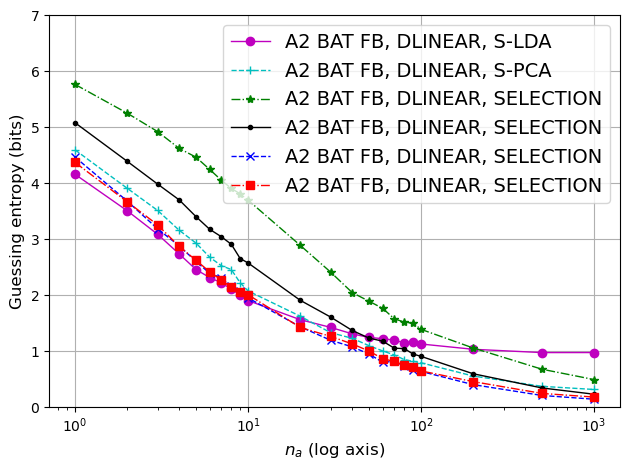

In [9]:
import os
import pickle
from do_show_results_templates_a2_bat_fb import get_ge_from_success_info, get_line_properties_templates, make_figures_ge
from get_uid_cmethod import get_uid_cmethod
import matplotlib.pyplot as plt
import numpy as np

with open(os.path.join(path_data, name_data), 'rb') as f:
    data = pickle.load(f)

# fdata = f'results/{name_data}.pkl'
rpath = 'figures/'
font_size = 12
options = 'gp'
# yrange = [0, 6.5]
yrange = [0, 7]
nr_traces_vec = list(range(1, 11)) + list(range(20, 101, 10)) + [200, 500, 1000]
len_na_vec = len(nr_traces_vec)

# Reset environment
plt.close('all')

nump = len(data[0][0]['idx_profile'])
rand_iter = data[0][0]['rand_iter']
nr_exp_ab = len(data[0])
L = [None] * nr_exp_ab
G = np.zeros((nr_exp_ab, len_na_vec))
slines_ab = [None] * nr_exp_ab
style = 'fancy'

for k in range(nr_exp_ab):
    if data[0][k]['atype'] == 'templatelda':
        L[k] = 'A2 BAT FB, DLINEAR, S-LDA'
    elif data[0][k]['atype'] == 'templatepca':
        L[k] = 'A2 BAT FB, DLINEAR, S-PCA'
    else:
        L[k] = 'A2 BAT FB, DLINEAR, SELECTION'

    g = get_ge_from_success_info(data[0][k]['success_info'], nr_traces_vec)
    G[k, :] = g['joint']
    # uid = get_uid_cmethod(cmethod, results[k]['cparams'])
    slines_ab[k] = get_line_properties_templates(k, style)

# Plot results
title_results = "" #f"A2D AB, BOFFSET, BAT FB, nump={nump}"
rprefix = f"a2d_ab_bat_fb_boffset_dlinear_n{nump}r_ls_r{rand_iter}_"
make_figures_ge(G, nr_traces_vec, rpath, rprefix, title_results, L, font_size, slines_ab, options, yrange)
